<a href="https://colab.research.google.com/github/kaustavsen93/EMBA_Dynamic_Pricing/blob/main/Dynamic_Pricing_BrickMortar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Data**

Downloading Dunnhumby dataset from kagglehub and loading the following files:


1.   transaction data
2.   product
3. hh_demographic




In [23]:
import kagglehub

# Download latest version
path_to = kagglehub.dataset_download("frtgnn/dunnhumby-the-complete-journey")

print("Path to dataset files:", path_to)

Path to dataset files: /root/.cache/kagglehub/datasets/frtgnn/dunnhumby-the-complete-journey/versions/1


In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

#Load Data Sets
transactions = pd.read_csv(path_to + "/transaction_data.csv")
products = pd.read_csv(path_to + "/product.csv")
causal_data = pd.read_csv(path_to + "/causal_data.csv")
customers = pd.read_csv(path_to + "/hh_demographic.csv")

# Check the dataset structure
print(transactions.head())
print(products.head())
print(customers.head())
print(causal_data.head())


   household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  
0       364        -0.60        1631        1          0.0                0.0  
1       364         0.00        1631        1          0.0                0.0  
2       364        -0.30        1631        1          0.0                0.0  
3       364         0.00        1631        1          0.0                0.0  
4       364        -0.39        1631        1          0.0                0.0  
   PRODUCT_ID  MANUFACTURER    DEPARTMENT     BRAND            COMMODITY_DESC  \


**Preprocessing the Data**

Key steps:



1.   Merge transaction data with product and customer data.
2.   Extract features for demand, inventory, customer behavior, and seasonality.



In [25]:
# Demand
# Calculate total sales per product
product_sales = transactions.groupby('PRODUCT_ID')['SALES_VALUE'].sum().reset_index()
# Rename the column in product_sales to avoid conflict during merge
product_sales.rename(columns={'SALES_VALUE': 'Total_Sales'}, inplace=True)

#products.drop(columns=['Product_Total_Sales_old'], inplace=True, errors='ignore')


products = pd.merge(products, product_sales, on='PRODUCT_ID', how='left', suffixes=('_old', '_upd'))

# Time and Seasons
transactions['WEEK_NO'] = transactions['WEEK_NO'].astype(int) # Convert to integer type
transactions['DATE'] = pd.to_datetime(transactions['DAY'] * 7 + (transactions['WEEK_NO']-1) * 7, unit='D', origin=pd.Timestamp('2009-12-31'))
transactions['month'] = transactions['DATE'].dt.month
transactions['year'] = transactions['DATE'].dt.year
transactions['day_of_week'] = transactions['DATE'].dt.dayofweek


# Customer Behaviour
# Recency, Frequency, Monetary (RFM) features
# Calculate last purchase date for each customer
last_purchase_date = transactions.groupby('household_key')['DATE'].max().reset_index()
last_purchase_date.rename(columns={'DATE': 'LAST_PURCHASE_DATE'}, inplace=True)

# Calculate number of purchases for each customer
purchase_frequency = transactions.groupby('household_key')['BASKET_ID'].count().reset_index()
purchase_frequency.rename(columns={'BASKET_ID': 'PURCHASE_FREQUENCY'}, inplace=True)

# Calculate total spending for each customer
total_spending = transactions.groupby('household_key')['SALES_VALUE'].sum().reset_index()
total_spending.rename(columns={'SALES_VALUE': 'TOTAL_SPENDING'}, inplace=True)

# Find the most frequent day_of_week for each household_key
day_of_week_mode = transactions.groupby('household_key')['day_of_week'].agg(lambda x: x.mode()[0]).reset_index()
day_of_week_mode.rename(columns={'day_of_week': 'FAVORITE_DAY_OF_WEEK'}, inplace=True)

# Find the most purchased product (mode) for each customer
favorite_product = transactions.groupby('household_key')['PRODUCT_ID'].agg(lambda x: x.mode()[0]).reset_index()
favorite_product.rename(columns={'PRODUCT_ID': 'FAVORITE_PRODUCT'}, inplace=True)

customers.rename(columns={'LAST_PURCHASE_DATE': 'LAST_PURCHASE_DATE_existing'}, inplace=True)


# Merge RFM features with customer data
customers = pd.merge(customers, last_purchase_date, on='household_key', how='left', suffixes=('_original', ''))

customers.drop(columns=['PURCHASE_FREQUENCY_original'], inplace=True, errors='ignore')
customers = pd.merge(customers, purchase_frequency, on='household_key', how='left', suffixes=('_original', ''))

customers.drop(columns=['TOTAL_SPENDING_original'], inplace=True, errors='ignore')
customers = pd.merge(customers, total_spending, on='household_key', how='left', suffixes=('_original', ''))

customers.drop(columns=['FAVORITE_DAY_OF_WEEK_original'], inplace=True, errors='ignore')
customers = pd.merge(customers, day_of_week_mode, on='household_key', how='left', suffixes=('_original', ''))

customers.drop(columns=['FAVORITE_PRODUCT_original'], inplace=True, errors='ignore')
customers = pd.merge(customers, favorite_product, on='household_key', how='left', suffixes=('_original', ''))

#customers.drop(columns=['Total_Sales'], inplace=True)

print(customers.head())

  AGE_DESC MARITAL_STATUS_CODE INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC  \
0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   
2    25-34                   U      25-34K        Unknown     2 Adults Kids   
3    25-34                   U      75-99K      Homeowner     2 Adults Kids   
4    45-54                   B      50-74K      Homeowner     Single Female   

  HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC  household_key LAST_PURCHASE_DATE  \
0                   2      None/Unknown              1         2025-06-19   
1                   2      None/Unknown              7         2025-07-10   
2                   3                 1              8         2025-06-19   
3                   4                 2             13         2025-07-10   
4                   1      None/Unknown             16         2025-02-06   

   PURCHASE_FREQUENCY  TOTAL_SPENDING  FAVORITE_DAY_OF_WEEK  F

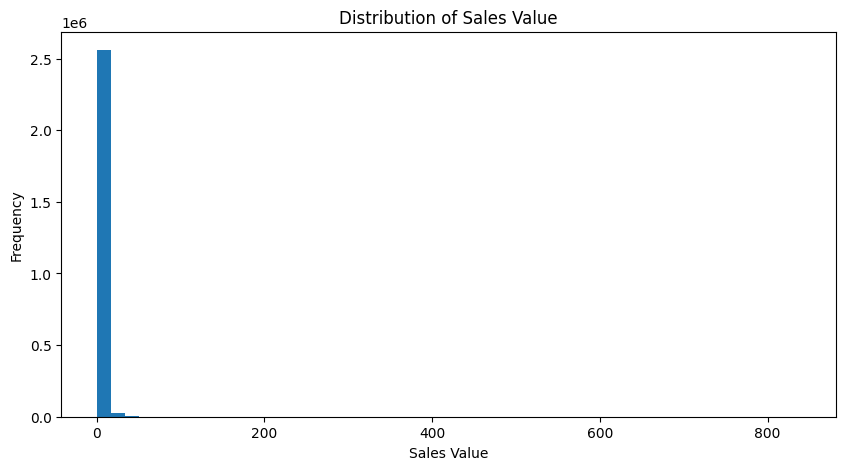

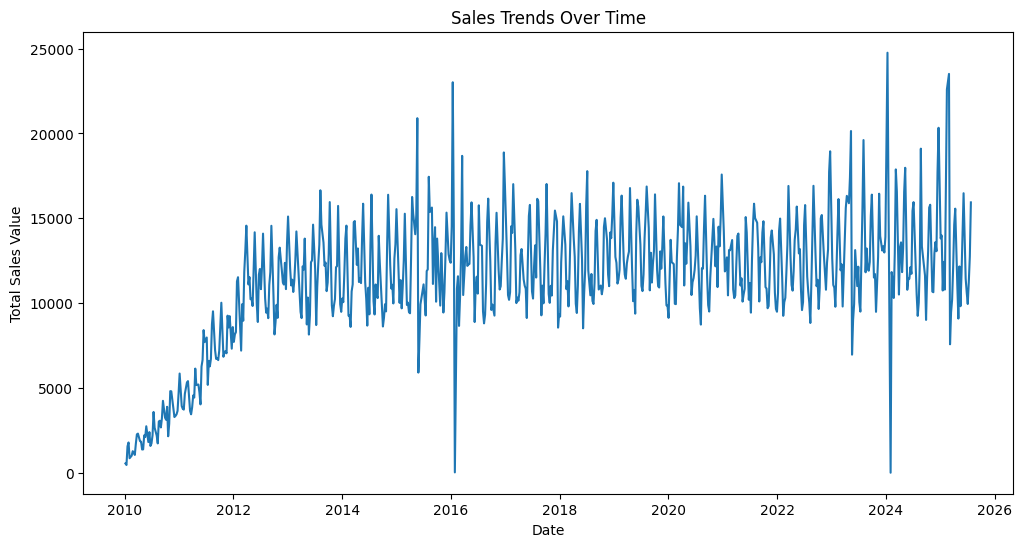

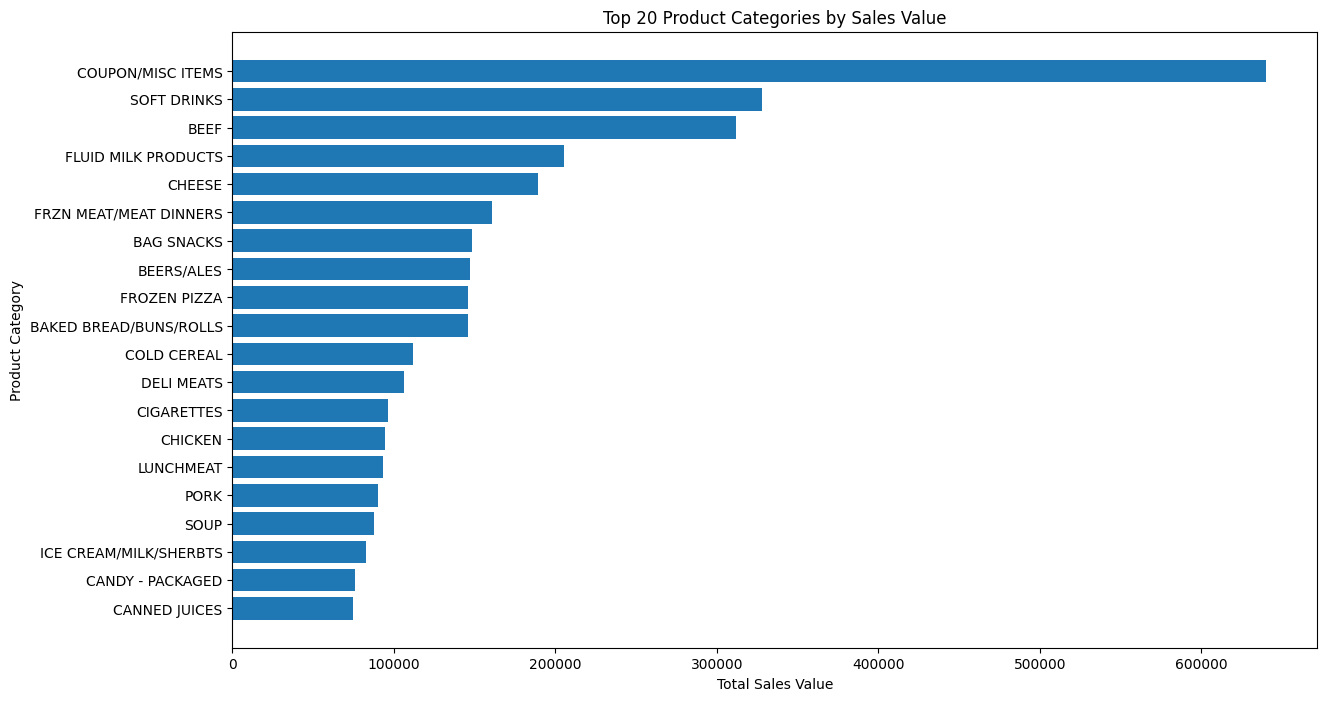

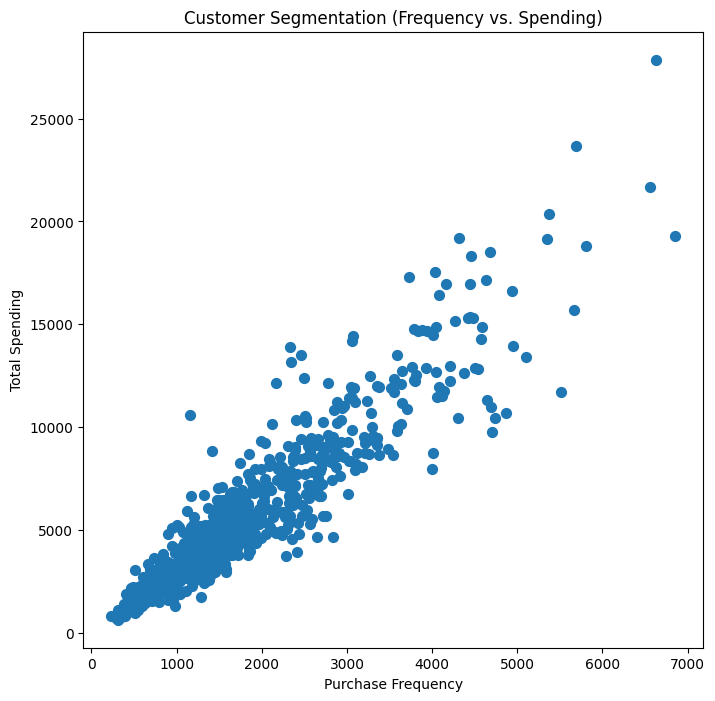

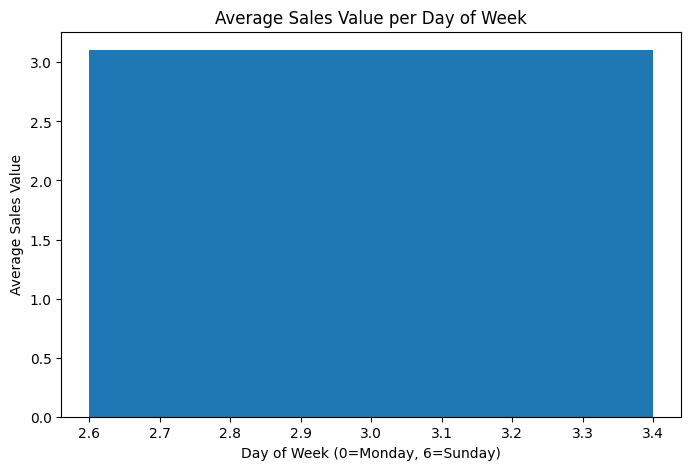

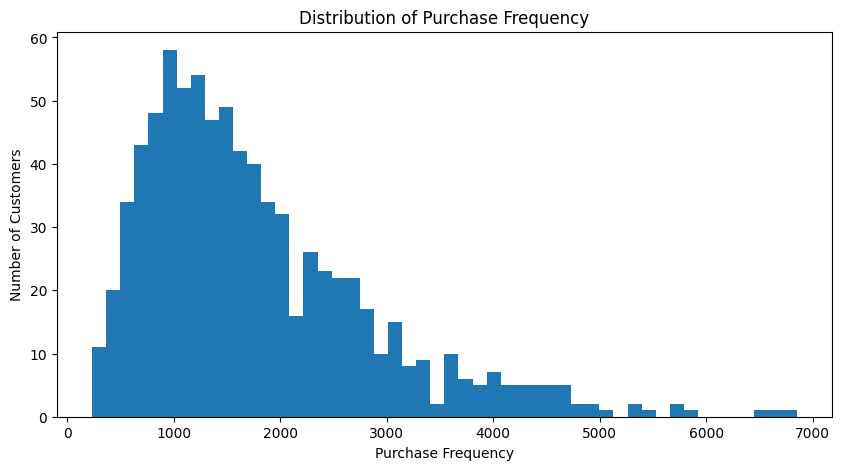

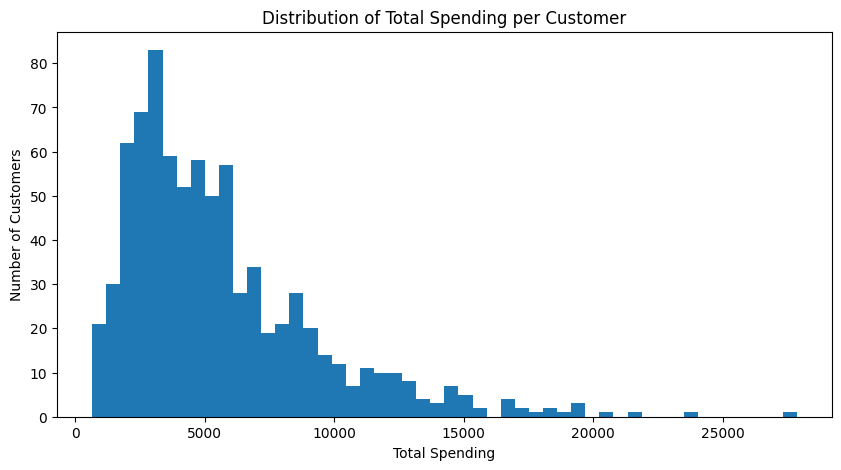

In [26]:
18# 1. Sales Distribution
plt.figure(figsize=(10, 5))
plt.hist(transactions['SALES_VALUE'], bins=50)
plt.title('Distribution of Sales Value')
plt.xlabel('Sales Value')
plt.ylabel('Frequency')
plt.show()


# 2. Sales Trends over Time
sales_by_date = transactions.groupby('DATE')['SALES_VALUE'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['DATE'], sales_by_date['SALES_VALUE'])
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Value')
plt.show()


# 3. Product Category Popularity
product_category_sales = transactions.groupby('PRODUCT_ID')['SALES_VALUE'].sum().reset_index()
product_category_sales = pd.merge(product_category_sales, products[['PRODUCT_ID', 'COMMODITY_DESC']], on='PRODUCT_ID', how='left')
product_category_sales = product_category_sales.groupby('COMMODITY_DESC')['SALES_VALUE'].sum().reset_index()
product_category_sales = product_category_sales.sort_values('SALES_VALUE', ascending=False)

plt.figure(figsize=(14, 8))
plt.barh(product_category_sales['COMMODITY_DESC'][:20], product_category_sales['SALES_VALUE'][:20])  # Top 20 categories
plt.title('Top 20 Product Categories by Sales Value')
plt.xlabel('Total Sales Value')
plt.ylabel('Product Category')
plt.gca().invert_yaxis()  # Invert y-axis to show highest sales at the top
plt.show()



# 4. Customer Segmentation (RFM - simplified example)
plt.figure(figsize=(8, 8))
plt.scatter(customers['PURCHASE_FREQUENCY'], customers['TOTAL_SPENDING'], s=50) # Size of marker represents Spending
plt.title('Customer Segmentation (Frequency vs. Spending)')
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Spending')
plt.show()



# 5. Average Sales Value per Day of Week
sales_by_day = transactions.groupby('day_of_week')['SALES_VALUE'].mean().reset_index()
plt.figure(figsize=(8, 5))
plt.bar(sales_by_day['day_of_week'], sales_by_day['SALES_VALUE'])
plt.title('Average Sales Value per Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Sales Value')
plt.show()



# 6. Distribution of Purchase Frequency
plt.figure(figsize=(10,5))
plt.hist(customers['PURCHASE_FREQUENCY'], bins=50)
plt.title('Distribution of Purchase Frequency')
plt.xlabel('Purchase Frequency')
plt.ylabel('Number of Customers')
plt.show()




# 7. Distribution of Total Spending per Customer
plt.figure(figsize=(10,5))
plt.hist(customers['TOTAL_SPENDING'], bins=50)
plt.title('Distribution of Total Spending per Customer')
plt.xlabel('Total Spending')
plt.ylabel('Number of Customers')
plt.show()

In [27]:
# Visualization functions

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label


def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
    plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price ($)");
    plt.xticks(range(T))
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

In [28]:
#Sample a single product, day, and customer segment
cust_sample = customers.sample(1)
print(cust_sample)
product_id = cust_sample['FAVORITE_PRODUCT'].values[0]
day_of_week = cust_sample['FAVORITE_DAY_OF_WEEK'].values[0]
customer_segment = cust_sample['MARITAL_STATUS_CODE'].values[0]
household_key = cust_sample['household_key'].values[0]

    AGE_DESC MARITAL_STATUS_CODE INCOME_DESC HOMEOWNER_DESC  HH_COMP_DESC  \
439    25-34                   U      15-24K        Unknown  1 Adult Kids   

    HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC  household_key LAST_PURCHASE_DATE  \
439                   2                 1           1363         2025-07-24   

     PURCHASE_FREQUENCY  TOTAL_SPENDING  FAVORITE_DAY_OF_WEEK  \
439                1245          4075.4                     3   

     FAVORITE_PRODUCT  
439           1082185  


In [29]:
import random

def demand_function(price, product_id, week_no, day_of_week, customer_segment):
    """Predicts demand based on price and other features."""
    # Example placeholder for demand calculation
    base_demand = products[products['PRODUCT_ID'] == product_id]['Total_Sales'].values[0] / T  # Average weekly sales as base demand
    price_sensitivity = -0.5
    segment_multiplier = 1

    if customer_segment == 1:
        segment_multiplier = 0.8  # Example: Segment 1 is less price sensitive
    elif customer_segment == 3:
        segment_multiplier = 1.2  # Example: Segment 3 is more price sensitive

    demand = base_demand + price_sensitivity * price * segment_multiplier

    # Seasonality adjustment (example):
    if week_no in range(20, 30):  # Example: Higher demand during these weeks
        demand *= 1.2
    if day_of_week >= 5:  # Weekend effect
        demand *= 1.1

    return max(0, demand)


def profit_t_response(price, product_id, week_no, day_of_week, customer_segment, unit_cost=0.5):  # Example unit cost
    demand = demand_function(price, product_id, week_no, day_of_week, customer_segment)
    profit = (price - unit_cost) * demand
    return profit


def profit_response(p, products_df, customer_behavior_df, transactions_df, unit_cost=0.5):
    """Calculates total profit over all time periods for a given price schedule."""
    # Randomly select a product_id and household_key
   # product_id = random.choice(products_df['PRODUCT_ID'].unique())
   # household_key = random.choice(customer_behavior_df['household_key'].unique())

    total_profit = 0
    for t in range(T):  # Iterate over all time periods (weeks)
        week_no = t + 1

        # Retrieve the day of the week based on transactions data
        day_of_week = transactions_df[(transactions_df['household_key'] == household_key) &
                                      (transactions_df['WEEK_NO'] == week_no)]['day_of_week'].values
        day_of_week = day_of_week[0] if len(day_of_week) > 0 else 0  # Default to 0 if no value found

        price_t = p[t]  # Price at time t

        # Calculate demand using the demand function
        customer_segment = customer_behavior_df[customer_behavior_df['household_key'] == household_key]['MARITAL_STATUS_CODE'].values
        customer_segment = customer_segment[0] if len(customer_segment) > 0 else 1  # Default to segment 1 if no value found

        demand_t = demand_function(price_t, product_id, week_no, day_of_week, customer_segment)

        # Calculate profit for the given time period
        profit_t = (price_t - unit_cost) * demand_t
        total_profit += profit_t

    return total_profit

In [30]:
# Function to calculate optimal constant price
def find_optimal_constant_price(price_grid, products_df, customer_behavior_df, transactions_df):
    """Find the optimal constant price across all time periods."""
    profits = np.array([
        profit_response(
            np.repeat(p, T),
            products_df,
            customer_behavior_df,
            transactions_df
        ) for p in price_grid
    ])

    # Find the price index with maximum profit
    p_idx = np.argmax(profits)
    optimal_price = price_grid[p_idx]
    max_profit = profits[p_idx]

    return optimal_price, max_profit

# Grid of possible prices
price_grid = np.linspace(0.5, 5.0, 10)  # Example: Prices between $0.5 and $5.0 in increments
T = len(transactions['WEEK_NO'].unique())
# Calculate optimal constant price
price_opt_const, max_profit = find_optimal_constant_price(price_grid, products, customers, transactions)

# Print results
print(f"Optimal constant price is {price_opt_const}, achieved profit is {max_profit}")

Optimal constant price is 5.0, achieved profit is 134100.35294117662


Optimal price schedule: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Achieved profit: 132556.49999999997


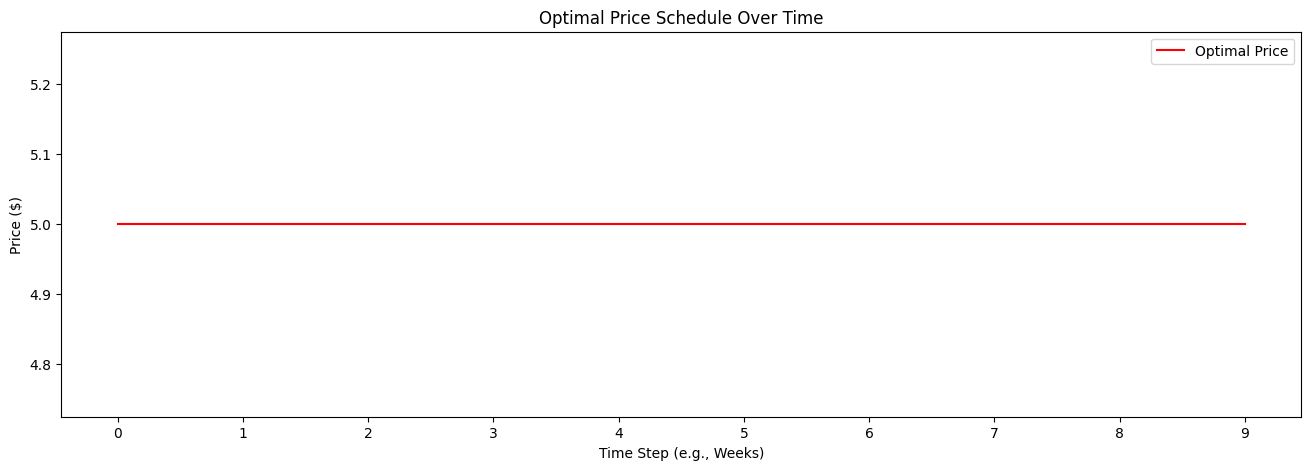

In [31]:
#Greedy Approach
import numpy as np
import matplotlib.pyplot as plt

def find_optimal_price_t(p_baseline, price_grid, t, products_df, customers_df,transactions_df):
    """Finds the optimal price for time t using a greedy search approach."""
    p_grid = np.tile(p_baseline, (len(price_grid), 1))  # Create a grid of prices
    p_grid[:, t] = price_grid  # Modify prices at time t for each row in the grid

    # Calculate profit for each price configuration in the grid
    profit_grid = np.array([
        profit_response(p,products_df, customers_df,transactions_df)
        for p in p_grid
    ])

    return price_grid[np.argmax(profit_grid)]  # Return the price with the highest profit

# Initialize parameters
T = 10  # Number of time steps (e.g., weeks)
price_opt_const = 2.0  # Starting price baseline
price_grid = np.linspace(1.0, 5.0, 10)  # Possible price points (e.g., $1 to $5)

# Baseline price schedule
p_opt = np.repeat(price_opt_const, T)

# Find optimal prices for each time step
def find_optimal_price_schedule(T, price_grid, products_df, customers_df,transactions_df):
    """Finds the optimal price schedule over T time steps."""
    p_opt = np.repeat(price_opt_const, T)  # Initialize price schedule
    for t in range(T):
        p_opt[t] = find_optimal_price_t(p_opt, price_grid, t, products_df, customers_df,transactions_df)
    return p_opt

# Calculate optimal price schedule
p_opt = find_optimal_price_schedule(T, price_grid, products, customers, transactions)

# Display results
achieved_profit = profit_response(p_opt, products, customers, transactions)
print(f"Optimal price schedule: {p_opt}")
print(f"Achieved profit: {achieved_profit}")

# Plot the optimal price schedule
plt.figure(figsize=(16, 5))
plt.title("Optimal Price Schedule Over Time")
plt.xlabel("Time Step (e.g., Weeks)")
plt.ylabel("Price ($)")
plt.xticks(np.arange(T))
plt.plot(np.arange(T), p_opt, c='red', label="Optimal Price")
plt.legend()
plt.show()

In [32]:
'''import numpy as np
import matplotlib.pyplot as plt

# Select random product_id and household_key
#product_id = products_df['PRODUCT_ID'].sample(1).values[0]
#household_key = customers_df['household_key'].sample(1).values[0]

# Function to calculate profit response
def profit_response(p, product_id, household_key, products_df, customer_behavior_df, transactions_df, unit_cost=0.5):
    """Calculates total profit over all time periods for a given price schedule."""
    total_profit = 0
    for t in range(T):  # Iterate over all time periods
        week_no = t + 1
        day_of_week = (t % 7) + 1  # Simulate day of the week
        customer_segment = customer_behavior_df.loc[
            customer_behavior_df['household_key'] == household_key, 'segment'
        ].values[0]
        price_t = p[t]
        demand_t = demand_function(price_t, product_id, week_no, day_of_week, customer_segment)
        profit_t = (price_t - unit_cost) * demand_t
        total_profit += profit_t
    return total_profit

# Function to calculate optimal constant price
def find_optimal_constant_price(price_grid, products_df, customer_behavior_df, transactions_df):
    """Find the optimal constant price across all time periods."""
    profits = np.array([
        profit_response(
            np.repeat(p, T),
            product_id,
            household_key,
            products_df,
            customer_behavior_df,
            transactions_df
        ) for p in price_grid
    ])
    p_idx = np.argmax(profits)  # Find the price index with maximum profit
    optimal_price = price_grid[p_idx]
    max_profit = profits[p_idx]
    return optimal_price, max_profit

# Function to find the optimal price at time t
def find_optimal_price_t(p_baseline, price_grid, t, products_df, customer_behavior_df, transactions_df):
    """Find the optimal price at time t using greedy search."""
    p_grid = np.tile(p_baseline, (len(price_grid), 1))  # Duplicate baseline prices
    p_grid[:, t] = price_grid  # Update price at time t
    profit_grid = np.array([
        profit_response(p, product_id, household_key, products_df, customer_behavior_df, transactions_df) for p in p_grid
    ])
    return price_grid[np.argmax(profit_grid)]  # Return price that maximizes profit

# Function to optimize prices over time
def optimize_prices(price_opt_const, price_grid, products_df, customer_behavior_df, transactions_df):
    """Perform greedy optimization to find optimal prices over time."""
    p_baseline = np.repeat(price_opt_const, T)
    p_opt = p_baseline.copy()
    for t in range(T):
        price_t = find_optimal_price_t(p_opt, price_grid, t, products_df, customer_behavior_df, transactions_df)
        p_opt[t] = price_t
    return p_opt

# Grid of possible prices
price_grid = np.linspace(0.5, 5.0, 20)  # Example: Prices between $0.5 and $5.0
T = 10  # Number of time periods (weeks or days)

# Step 1: Calculate the optimal constant price
price_opt_const, max_profit = find_optimal_constant_price(price_grid, products_df, customer_behavior_df, transactions_df)
print(f"Optimal constant price is {price_opt_const}, achieved profit is {max_profit}")

# Step 2: Optimize prices over time
p_opt = optimize_prices(price_opt_const, price_grid, products_df, customer_behavior_df, transactions_df)
print("Optimal price schedule:", p_opt)
print(f"Achieved profit is {profit_response(p_opt, product_id, household_key, products_df, customer_behavior_df, transactions_df)}")

# Plot the optimal price schedule
plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.xticks(np.arange(T))
plt.plot(np.arange(T), p_opt, c='red')
plt.title("Optimal Price Schedule Over Time")
plt.show()
'''

'import numpy as np\nimport matplotlib.pyplot as plt\n\n# Select random product_id and household_key\n#product_id = products_df[\'PRODUCT_ID\'].sample(1).values[0]\n#household_key = customers_df[\'household_key\'].sample(1).values[0]\n\n# Function to calculate profit response\ndef profit_response(p, product_id, household_key, products_df, customer_behavior_df, transactions_df, unit_cost=0.5):\n    """Calculates total profit over all time periods for a given price schedule."""\n    total_profit = 0\n    for t in range(T):  # Iterate over all time periods\n        week_no = t + 1\n        day_of_week = (t % 7) + 1  # Simulate day of the week\n        customer_segment = customer_behavior_df.loc[\n            customer_behavior_df[\'household_key\'] == household_key, \'segment\'\n        ].values[0]\n        price_t = p[t]\n        demand_t = demand_function(price_t, product_id, week_no, day_of_week, customer_segment)\n        profit_t = (price_t - unit_cost) * demand_t\n        total_profi

Pricing Policy Optimization Using DQN

In [36]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
import matplotlib.pyplot as plt

# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition tuple for experience replay
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class OptimizedPricingDQN:
    def __init__(self, products_df, customers_df, transactions_df,
                 price_grid=np.linspace(0.1, 2.0, 20),  # Reduced price grid points
                 num_episodes=10,  # Reduced episodes
                 batch_size=128,    # Optimal batch size
                 learning_rate=0.001):

        # Data preprocessing
        self.products = products_df
        self.customers = customers_df
        self.transactions = transactions_df

        # Environment parameters
        self.price_grid = price_grid
        self.T = len(transactions_df['WEEK_NO'].unique())

        # Hyperparameters
        self.num_episodes = num_episodes
        self.batch_size = batch_size
        self.gamma = 0.99  # Slightly reduced discount factor
        self.eps_start = 0.9
        self.eps_end = 0.05
        self.eps_decay = 200

        # Neural Network
        self.state_size = 2 * self.T
        self.action_size = len(self.price_grid)

        # Initialize networks
        self.policy_net = self._build_network().to(device)
        self.target_net = self._build_network().to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)

        # Replay Memory
        self.memory = ReplayMemory(10000)

        # Tracking
        self.return_trace = []
        self.price_trace = []

    def _build_network(self):
        return nn.Sequential(
            nn.Linear(self.state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )

    def _demand_function(self, price, product_id, week_no, day_of_week, customer_segment):
        base_demand = self.products[self.products['PRODUCT_ID'] == product_id]['Total_Sales'].values[0] / self.T
        price_sensitivity = -0.5
        segment_multiplier = 1.0

        if customer_segment == 1:
            segment_multiplier = 0.8
        elif customer_segment == 3:
            segment_multiplier = 1.2

        demand = base_demand + price_sensitivity * price * segment_multiplier

        # Seasonality and weekend adjustments
        if 20 <= week_no <= 30:
            demand *= 1.2
        if day_of_week >= 5:
            demand *= 1.1

        return max(0, demand)

    def _profit_calculation(self, price, product_id, week_no, day_of_week, customer_segment, unit_cost=0.5):
        demand = self._demand_function(price, product_id, week_no, day_of_week, customer_segment)
        return (price - unit_cost) * demand

    def train(self):
        for episode in range(self.num_episodes):
            # Randomly select product and customer segment
            product_id = self.products.sample(1)['PRODUCT_ID'].values[0]
            customer_segment = self.customers.sample(1)['MARITAL_STATUS_CODE'].values[0]

            state = np.zeros(2 * self.T)
            total_reward = 0
            price_schedule = []

            for t in range(self.T):
                week_no = t + 1
                day_of_week = self.transactions[self.transactions['WEEK_NO'] == week_no].sample(1)['day_of_week'].values[0]

                # Epsilon-greedy action selection
                if random.random() > self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * episode / self.eps_decay):
                    with torch.no_grad():
                        q_values = self.policy_net(torch.FloatTensor(state).to(device))
                    action = q_values.argmax().item()
                else:
                    action = random.randrange(len(self.price_grid))

                # Take action
                next_state = np.zeros_like(state)
                next_state[0] = self.price_grid[action]
                next_state[1:self.T] = state[0:self.T-1]
                next_state[self.T + t] = 1

                reward = self._profit_calculation(
                    next_state[0], product_id, week_no,
                    day_of_week, customer_segment
                )

                # Store transition
                self.memory.push(
                    torch.FloatTensor(state),
                    torch.tensor([action]),
                    torch.FloatTensor(next_state) if t != self.T - 1 else None,
                    torch.tensor([reward])
                )

                state = next_state
                total_reward += reward
                price_schedule.append(self.price_grid[action])

                # Learn
                self._optimize_model()

            # Update tracking
            self.return_trace.append(total_reward)
            self.price_trace.append(price_schedule)

            # Periodic target network update
            if episode % 20 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                print(f'Episode {episode}/{self.num_episodes}')

        return self.return_trace, self.price_trace

    def _optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample batch from replay memory
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # Create tensors
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                      device=device, dtype=torch.bool)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q values
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute next state values
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        # Compute expected Q values
        expected_state_action_values = reward_batch.squeeze() + (self.gamma * next_state_values)

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values.squeeze(), expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1)
        self.optimizer.step()

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Usage example
def plot_returns_and_prices(return_trace, price_trace):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot returns
    ax1.plot(return_trace)
    ax1.set_title('Episode Returns')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Return')

    # Plot price schedules
    ax2.boxplot(price_trace)
    ax2.set_title('Price Distribution')
    ax2.set_xlabel('Time Period')
    ax2.set_ylabel('Price')

    plt.tight_layout()
    plt.show()

# Main execution
def run_pricing_optimization(products, customers, transactions):
    pricing_dqn = OptimizedPricingDQN(products, customers, transactions)
    return_trace, price_trace = pricing_dqn.train()

    # Analyze results
    best_profits = []
    for price_schedule in price_trace[-10:]:
        try:
           # # Sample a single product, day, and customer segment
            #product_id = products.sample(1)['PRODUCT_ID'].values[0]
            #day_of_week = transactions.sample(1)['day_of_week'].values[0]
            #customer_segment = customers.sample(1)['MARITAL_STATUS_CODE'].values[0]

            # Calculate total profit for the entire price schedule
            total_profit = sum(
                pricing_dqn._profit_calculation(
                    price,
                    product_id,
                    week_no + 1,  # Assuming week numbers start from 1
                    day_of_week,
                    customer_segment
                )
                for week_no, price in enumerate(price_schedule)
            )

            best_profits.append(total_profit)
        except Exception as e:
            print(f"Error calculating profit for schedule: {e}")

        # Sort the calculated profits
        best_profits = sorted(best_profits)

        for profit in best_profits:
          print(f'Best profit results: {profit}')


run_pricing_optimization(products, customers, transactions)
# Visualization
#plot_returns_and_prices(return_trace, price_trace)

   # return return_trace, price_trace

Episode 0/10
Best profit results: 20512.178588235296
Best profit results: 18059.52925490196
Best profit results: 20512.178588235296
Best profit results: 18059.52925490196
Best profit results: 18727.734235294127
Best profit results: 20512.178588235296
Best profit results: 18059.52925490196
Best profit results: 18429.78745098039
Best profit results: 18727.734235294127
Best profit results: 20512.178588235296
Best profit results: 18059.52925490196
Best profit results: 18429.78745098039
Best profit results: 18727.734235294127
Best profit results: 20512.178588235296
Best profit results: 21989.05015686276
Best profit results: 18059.52925490196
Best profit results: 18247.041137254913
Best profit results: 18429.78745098039
Best profit results: 18727.734235294127
Best profit results: 20512.178588235296
Best profit results: 21989.05015686276
Best profit results: 18059.52925490196
Best profit results: 18247.041137254913
Best profit results: 18429.78745098039
Best profit results: 18727.734235294127

In [ ]:
'''
import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Define the price grid (modify as needed)
price_grid = np.linspace(0.1, 2.0, 50)  # Example: 20 price points between 0.1 and 2.0
T = len(transactions['WEEK_NO'].unique()) # Number of time periods (weeks)


# A cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetworkDQN, self).__init__()
        layers = [
              nn.Linear(state_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, action_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        q_values = self.model(x)
        return q_values

class AnnealedEpsGreedyPolicy(object):
    def __init__(self, eps_start = 0.9, eps_end = 0.05, eps_decay = 400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            return random.randrange(len(q_values))

GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512

def update_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def env_intial_state():
    return np.repeat(0, 2*T)

def env_step(t, state, action, product_id, week_no, day_of_week, customer_segment):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    next_state[T + t] = 1
    reward = profit_t_response(next_state[0], product_id, week_no, day_of_week, customer_segment)
    return next_state, reward

def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)

policy_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 10
return_trace = []
p_trace = [] # price schedules used in each episode

#product_id = products.sample(1)['PRODUCT_ID'].values[0]
#customer_segment = customers.sample(1)['MARITAL_STATUS_CODE'].values[0] # Example using marital status as segment. Change as needed.


for i_episode in range(num_episodes):
    # Example: Choose a random product, customer segment for each episode
    print(str(product_id) + "      "+ str(customer_segment))
    state = env_intial_state()
    reward_trace = []
    p = []
    for t in range(T):
        week_no = t + 1 # Assuming weeks start from 1
        #day_of_week = transactions[transactions['WEEK_NO'] == week_no].sample(1)['day_of_week'].values[0] # Randomly select a day of week within the week

        with torch.no_grad():
            q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward = env_step(t, state, action, product_id, week_no, day_of_week, customer_segment)

        # Store the transition in memory
        memory.push(to_tensor(state),
                    to_tensor_long(action),
                    to_tensor(next_state) if t != T - 1 else None,
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait = True)
        print(f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')

plot_return_trace(return_trace)

fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, 5, 10, fig.number)

best_profits = sorted(
    profit_response(s, products, customers,transactions,0.5)
    for s in p_trace
)[-10:]

for profit in best_profits:
    print(f'Best profit results: {profit}')

print(T)'''

In [ ]:
def moving_average(data, window_size):
    """
    Compute the moving average of a given data series.
    Args:
        data (list or array): The data series to smooth.
        window_size (int): The size of the moving average window.
    Returns:
        np.array: Smoothed data with the moving average applied.
    """
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


# After training, calculate and plot the moving average of the reward trace
window_size = 3  # Set the moving average window size
smoothed_rewards = moving_average(return_trace, window_size)

# Plot the original reward trace and the smoothed rewards
plt.figure(figsize=(12, 6))
plt.plot(return_trace, label='Original Reward Trace', alpha=0.5, color='gray')
plt.plot(range(window_size - 1, len(return_trace)), smoothed_rewards, label='Moving Average (Window Size: 50)', color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Progression with Moving Average')
plt.legend()
plt.grid()
plt.show()
